In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
import tensorflow as tf
import os
import cv2
import keras
import random

In [4]:
benign_path = r"C:\Users\Anandan Suresh\Documents\final year project\lung cancer dataset\Benign cases"
malignant_path = r"C:\Users\Anandan Suresh\Documents\final year project\lung cancer dataset\Malignant cases"
normal_path = r"C:\Users\Anandan Suresh\Documents\final year project\lung cancer dataset\Normal cases"

img_classes = ["Benign cases", "Malignant cases", "Normal cases"]
path_list = [benign_path, malignant_path, normal_path]

img_path = []
class_labels = []
for i, dir_list in enumerate(path_list):
    name_img = os.listdir(dir_list)
    for name_file in name_img:
        img = os.path.join(dir_list,name_file)
        img_path.append(img)
        class_labels.append(img_classes[i])

df = pd.DataFrame({"img_path" : img_path,
                  "label" : class_labels})

df.head()

img_path         label
0  C:\Users\Anandan Suresh\Documents\final year p...  Benign cases
1  C:\Users\Anandan Suresh\Documents\final year p...  Benign cases
2  C:\Users\Anandan Suresh\Documents\final year p...  Benign cases
3  C:\Users\Anandan Suresh\Documents\final year p...  Benign cases
4  C:\Users\Anandan Suresh\Documents\final year p...  Benign cases

In [5]:
print(df['label'].value_counts())

label
Malignant cases    561
Normal cases       416
Benign cases       120
Name: count, dtype: int64


In [6]:
for category, group in df.groupby("label"):
    fig, ax = plt.subplots(1,4, figsize = (8,8))
    ax = ax.ravel()
    for i, (_,r) in enumerate(group.sample(4).iterrows()):
        img = cv2.imread(r.img_path)
        ax[i].imshow(img)
        ax[i].axis("off")
        ax[i].set_title(r.label)
    plt.show()

In [9]:
# Augmentation for Benign Cases
augmented_benign_dir = r"C:\Users\Anandan Suresh\Documents\final year project\lung cancer dataset\augmented_benign"
os.makedirs(augmented_benign_dir, exist_ok=True)

benign_augmenter = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Augment Benign images
benign_images = [os.path.join(benign_path, img) for img in os.listdir(benign_path)]
augment_count = 480 - len(benign_images)

augmented_benign_images = []
for i in range(augment_count):
    img_path = random.choice(benign_images)
    img = tf.keras.preprocessing.image.load_img(img_path)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array.reshape((1,) + img_array.shape)

    save_prefix = f"aug_{i}"
    for batch in benign_augmenter.flow(img_array, batch_size=1, save_to_dir=augmented_benign_dir, save_prefix=save_prefix, save_format='jpg'):
        augmented_benign_images.append(os.path.join(augmented_benign_dir, f"{save_prefix}_0.jpg"))
        break

# Combine original and augmented benign images
all_benign_images = benign_images + augmented_benign_images



In [10]:

def add_salt_pepper_noise(image, salt_prob, pepper_prob):
    noisy_image = image.copy()
    total_pixels = image.size

    # Add salt (white) noise
    num_salt = int(total_pixels * salt_prob)
    coords = [np.random.randint(0, i - 1, num_salt) for i in image.shape[:2]]
    noisy_image[coords[0], coords[1]] = 255

    # Add pepper (black) noise
    num_pepper = int(total_pixels * pepper_prob)
    coords = [np.random.randint(0, i - 1, num_pepper) for i in image.shape[:2]]
    noisy_image[coords[0], coords[1]] = 0

    return noisy_image


In [11]:

output_dir = r"C:\Users\Anandan Suresh\Documents\final year project\lung cancer dataset\output"

# Create output directory and subdirectories for benign, malignant, and normal images
os.makedirs(output_dir, exist_ok=True)
for label in ["Benign cases", "Malignant cases", "Normal cases"]:
    os.makedirs(os.path.join(output_dir, label), exist_ok=True)


# Prepare data paths for benign, malignant, and normal images
class_dirs = {
    "Benign cases": [os.path.join(benign_path, img) for img in os.listdir(benign_path)] +
                    [os.path.join(augmented_benign_dir, img) for img in os.listdir(augmented_benign_dir)],
    "Malignant cases": [os.path.join(malignant_path, img) for img in os.listdir(malignant_path)],
    "Normal cases": [os.path.join(normal_path, img) for img in os.listdir(normal_path)],
}

# Add noise and copy images for each class
for label, image_list in class_dirs.items():
    noise_probability = 0.3  # 30% of images will have noise
    num_noisy_images = int(len(image_list) * noise_probability)

    # Select images randomly to apply noise
    noisy_images_subset = random.sample(image_list, num_noisy_images)

    # Copy the original list to keep track of remaining images
    remaining_images = [img for img in image_list if img not in noisy_images_subset]

    for img_path in noisy_images_subset:
        img = cv2.imread(img_path)
        if img is None:
            continue  # Skip if image can't be read

        noisy_img = add_salt_pepper_noise(img, salt_prob=0.02, pepper_prob=0.02)

        # Save noisy image directly in the class folder
        base_name = os.path.basename(img_path)
        save_path = os.path.join(output_dir, label, f"noisy_{base_name}")
        cv2.imwrite(save_path, noisy_img)

    # Save remaining original images in the class folder
    for img_path in remaining_images:
        img = cv2.imread(img_path)
        base_name = os.path.basename(img_path)
        save_path = os.path.join(output_dir, label, base_name)
        cv2.imwrite(save_path, img)

    # Print the total number of images in the combined list for this class
    print(f"Total images in {label} after processing: {len(remaining_images) + num_noisy_images}")

print("All images have been saved to the 'output' directory.")


Total images in Benign cases after processing: 480
Total images in Malignant cases after processing: 561
Total images in Normal cases after processing: 416
All images have been saved to the 'output' directory.


In [12]:
# Prepare the dataset
classes = ["Benign cases", "Malignant cases", "Normal cases"]
image_paths = []
class_labels = []

# Access folders and load file paths
for label in classes:
    class_folder = os.path.join(output_dir, label)
    images = [os.path.join(class_folder, img) for img in os.listdir(class_folder) if img.endswith(('.jpg', '.png'))]
    image_paths.extend(images)
    class_labels.extend([label] * len(images))

# Create a DataFrame
df_balanced = pd.DataFrame({"img_path": image_paths, "label": class_labels})
print(f"Initial class distribution:\n{df_balanced['label'].value_counts()}")


Initial class distribution:
label
Malignant cases    561
Benign cases       480
Normal cases       416
Name: count, dtype: int64


In [13]:
# Function to downsample any class
def downsample_class(df, class_name, target_count):
    class_subset = df[df['label'] == class_name]
    if len(class_subset) > target_count:
        class_subset = class_subset.sample(target_count, random_state=42)
    return pd.concat([df[df['label'] != class_name], class_subset])

df_balanced = downsample_class(df_balanced, "Benign cases", target_count=416)
df_balanced = downsample_class(df_balanced, "Malignant cases", target_count=416)
df_balanced = downsample_class(df_balanced, "Normal cases", target_count=416)

print(f"Class distribution after downsampling:\n{df_balanced['label'].value_counts()}")

Class distribution after downsampling:
label
Benign cases       416
Malignant cases    416
Normal cases       416
Name: count, dtype: int64


In [14]:
train_ratio = 0.70
test_ratio = 0.15
val_ratio = 0.15

df_train, df_test_val = train_test_split(df_balanced, train_size = train_ratio, random_state = 42)
df_test, df_val = train_test_split(df_test_val, train_size = test_ratio/(test_ratio+val_ratio), random_state = 42)

print(f"Train shape = {df_train.shape}")
print(f"Test shape = {df_test.shape}")
print(f"Validation shape = {df_val.shape}")


Train shape = (873, 2)
Test shape = (187, 2)
Validation shape = (188, 2)


In [15]:
def preprocessing_denoise(img):
    denoise_img = cv2.medianBlur(img, 1)
    denoise_img = cv2.cvtColor(denoise_img, cv2.COLOR_BGR2RGB)
    return denoise_img

Image Data Generator

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [17]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

image_size = (IMG_WIDTH, IMG_HEIGHT)
batch_size = 32

TRAIN_DATAGEN = ImageDataGenerator(rescale = 1./255.)
                                  #  preprocessing_function = preprocessing_denoise,
                                  # rotation_range = 30,
                                  # width_shift_range = 0.1,
                                  # height_shift_range = 0.2,
                                  # shear_range = 0.1,
                                  # zoom_range = 0.2,
                                  # horizontal_flip = True)

TEST_DATAGEN = ImageDataGenerator(rescale = 1./255.)

train_generator = TRAIN_DATAGEN.flow_from_dataframe(
    df_train,
    x_col = "img_path",
    y_col = "label",
    target_size = image_size,
    random_state=42,
    batch_size = batch_size,
    color_mode = "rgb",
    class_mode = "categorical",
    shuffle = True
)

val_generator = TEST_DATAGEN.flow_from_dataframe(
    df_val,
    x_col = "img_path",
    y_col = "label",
    target_size = image_size,
    batch_size = batch_size,
    random_state=42,
    color_mode = "rgb",
    class_mode = "categorical",
    shuffle = True
)

test_generator = TEST_DATAGEN.flow_from_dataframe(
    df_test,
    x_col = "img_path",
    y_col = "label",
    target_size = image_size,
    batch_size = batch_size,
    random_state = 42,
    color_mode = "rgb",
    class_mode = "categorical",
    shuffle = True
)

Found 873 validated image filenames belonging to 3 classes.
Found 188 validated image filenames belonging to 3 classes.
Found 187 validated image filenames belonging to 3 classes.


In [18]:
train_generator.class_indices

{'Benign cases': 0, 'Malignant cases': 1, 'Normal cases': 2}

In [19]:
test_generator.class_indices

{'Benign cases': 0, 'Malignant cases': 1, 'Normal cases': 2}

In [20]:
classes = list(train_generator.class_indices.keys())

class_counts = dict(zip(classes, [list(train_generator.classes).count(i) for i in range(len(classes))]))


print(class_counts)

{'Benign cases': 285, 'Malignant cases': 288, 'Normal cases': 300}


In [21]:
#Weight Class
class_weights = class_weight.compute_class_weight(
           class_weight = 'balanced',
            classes = np.unique(train_generator.classes), 
            y = train_generator.classes)

train_class_weights = dict(enumerate(class_weights))

for idx, weight, in train_class_weights.items():
    class_name = classes[idx]
    print(f"{class_name} : {weight}")

Benign cases : 1.0210526315789474
Malignant cases : 1.0104166666666667
Normal cases : 0.97


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization,Input,Layer
from tensorflow.keras.optimizers import Adam


CNN model

In [19]:

model1 = Sequential([
    Input(shape=(224, 224, 3)),
    Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), input_shape=(224, 224, 3), activation="relu", padding="same"),
    MaxPool2D(pool_size=(2, 2)),
    BatchNormalization(),
    
    Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="valid", activation="relu"),
    MaxPool2D(pool_size=(2, 2)),
    BatchNormalization(),
    
    Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding="valid", activation="relu"),
    MaxPool2D(pool_size=(2, 2)),
    BatchNormalization(),
    
    Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding="valid", activation="relu"),
    MaxPool2D(pool_size=(2, 2)),
    BatchNormalization(),
    
    Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding="valid", activation="relu"),
    MaxPool2D(pool_size=(2, 2)),
    BatchNormalization(),
    
    Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding="valid", activation="relu"),
    MaxPool2D(pool_size=(2, 2)),
    BatchNormalization(),
    
    Flatten(),
    Dense(4096, activation="relu"),
    Dropout(0.5),
    Dense(256, activation="relu"),
    Dropout(0.25),
    Dense(3, activation="softmax")
])


C:\Users\Anandan Suresh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
model1.compile(
    loss = "categorical_crossentropy",
    optimizer = "adam",
    metrics = ["accuracy"],
)

In [58]:
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [22]:
epochs=50

In [ ]:
history = model1.fit(train_generator,
                   steps_per_epoch = len(train_generator),
                   batch_size = 32,
                   validation_data = val_generator,
                   validation_steps = len(val_generator),
                   class_weight = train_class_weights,
                   callbacks=[
                               EarlyStopping(monitor = "val_loss",patience = 5,restore_best_weights = True), 
                               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, mode='min') 
                              ],
                   epochs = epochs)

In [50]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [33]:
def history_plot(epochs, history):
    fig1 = make_subplots()
    fig1.add_trace(go.Scatter(x = np.arange(1,epochs+1), y = history.history["accuracy"], name = "Training Accuracy"))
    fig1.add_trace(go.Scatter(x = np.arange(1,epochs+1), y = history.history["val_accuracy"], name = "Validation Accuracy"))
    fig1.update_layout(title = "Training and Validation Accuracy", xaxis_title = "Epoch", yaxis_title = "Accuracy")
    fig1.show()

    fig2 = make_subplots()
    fig2.add_trace(go.Scatter(x = np.arange(1,epochs+1), y = history.history["loss"], name = "Training Loss"))
    fig2.add_trace(go.Scatter(x = np.arange(1,epochs+1), y = history.history["val_loss"], name = "Validation Loss"))
    fig2.update_layout(title = "Training and Validation Loss", xaxis_title = "Epoch", yaxis_title = "Loss")
    fig2.show()

# history_plot(epochs, history)

In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score,classification_report

In [24]:
def evaluate_model(model, test_generator):
    
    results = model.evaluate(test_generator, verbose=0)
    test_loss, test_accuracy = results
    
    y_true = test_generator.classes  
    y_pred = model.predict(test_generator, verbose=0)
    y_pred_classes = y_pred.argmax(axis=1) 
    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    f1 = f1_score(y_true, y_pred_classes, average='weighted')
    print(classification_report(y_true,y_pred_classes))
    print(f"Test Loss = {results[0]}")
    print(f"Test Accuracy = {results[1]}")
    print(f"Precision = {precision}")
    print(f"Recall = {recall}")
    print(f"F1 Score = {f1}")


In [ ]:
evaluate_model(model1, test_generator)

In [ ]:
model1.summary()

In [ ]:
model1.save("CNN(Custom).keras")

Pretrained Model InceptionV3

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
base_model = InceptionV3(input_shape = (IMG_WIDTH, IMG_HEIGHT, 3), include_top = False, weights = "imagenet")

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model2 = Sequential()
model2.add(Input(shape = (IMG_WIDTH, IMG_HEIGHT, 3)))
model2.add(base_model)
model2.add(Flatten())
model2.add(Dense(1024, activation = "relu"))
model2.add(Dropout(0.35))
model2.add(Dense(512,activation="relu"))
model2.add(Dropout(0.3))
model2.add(Dense(256,activation="relu"))
model2.add(Dropout(0.25))
model2.add(Dense(3, activation = "softmax"))

print(model2.summary())

In [ ]:
epochs=50

In [ ]:
model2.compile(optimizer = Adam(0.0005),
             loss = "categorical_crossentropy",
             metrics = ["accuracy"])
history = model2.fit(train_generator,
                   steps_per_epoch = len(train_generator),
                   batch_size = 64,
                   validation_data = val_generator,
                   validation_steps = len(val_generator),
                   class_weight = train_class_weights,
                   callbacks=[
                               EarlyStopping(monitor = "val_loss",patience = 5,restore_best_weights = True), 
                               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
                              ],
                   epochs = 50)

In [ ]:
history_plot(epochs, history)

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])

Fine Tuning Pretrained Model : InceptionV3

In [ ]:
base_model.trainable = True

for l in base_model.layers[:10]:
    print(l.name, l.trainable)

model2.compile(optimizer = Adam(0.00001),
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

print(model2.summary())

In [ ]:
history = model2.fit(train_generator,
                   steps_per_epoch = len(train_generator),
                   batch_size = 32,
                   validation_data = val_generator,
                   validation_steps = len(val_generator),
                   class_weight = train_class_weights,
                   callbacks=[
                               EarlyStopping(monitor = "val_loss",patience = 5,restore_best_weights = True), 
                               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
                              ],
                   epochs = epochs)

In [ ]:
history_plot(epochs, history)

In [ ]:
evaluate_model(model2, test_generator)

In [ ]:
model2.save("InceptionV3.h5")

Pretrained Model VGG-16

In [ ]:
from keras.applications.vgg16 import VGG16

In [ ]:
base_model_vgg16 = VGG16(input_shape = (IMG_WIDTH, IMG_HEIGHT, 3), include_top = False, weights = "imagenet")

In [ ]:
for layer in base_model_vgg16.layers:
    layer.trainable = False

In [ ]:
model3 = Sequential()
model3.add(Input(shape = (IMG_WIDTH, IMG_HEIGHT, 3)))
model3.add(base_model)
model3.add(Flatten())
model3.add(Dense(1024, activation = "relu"))
model3.add(Dropout(0.4))
model3.add(Dense(3, activation = "softmax"))

print(model3.summary())

In [ ]:
model3.compile(optimizer = Adam(0.0005),
             loss = "categorical_crossentropy",
             metrics = ["accuracy"])

epochs = 50
history = model3.fit(train_generator,
                   steps_per_epoch = len(train_generator),
                   batch_size = 32,
                   validation_data = val_generator,
                   validation_steps = len(val_generator),
                   class_weight = train_class_weights,
                   callbacks=[
                               EarlyStopping(monitor = "val_loss",patience = 5,restore_best_weights = True), 
                               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, mode='min') 
                              ],
                   epochs = epochs)

In [ ]:
history_plot(epochs, history)

In [ ]:
evaluate_model(model3,test_generator)

Fine Tuning Model VGG16

In [ ]:
base_model_vgg16.trainable = True
set_trainable = False
for layer in base_model_vgg16.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

model3.compile(optimizer = Adam(0.00001),
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

In [ ]:
epochs = 50
history = model3.fit(train_generator,
                   steps_per_epoch = len(train_generator),
                   batch_size = 32,
                   validation_data = val_generator,
                   validation_steps = len(val_generator),
                   class_weight = train_class_weights,
                   callbacks=[
                               EarlyStopping(monitor = "val_loss",patience = 5,restore_best_weights = True), 
                               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, mode='min') 
                              ],
                   epochs = epochs)

In [ ]:
# history_plot(epochs,history)

In [ ]:
evaluate_model(model3, test_generator)

In [ ]:
model3.save("VGG16.h5")

InceptionResidual Network

In [25]:
from tensorflow.keras import Model

In [26]:

class QuadDense(Layer):
    def __init__(self, units=64, activation = 'relu'):
        super(QuadDense, self).__init__()
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        w1_init = tf.random_normal_initializer()
        self.w1 = tf.Variable(name = 'kernel_1', initial_value = w1_init(shape = (input_shape[-1], self.units), dtype = 'float32'))
        
        w2_init = tf.random_normal_initializer()
        self.w2 = tf.Variable(name = 'kernel_2', initial_value = w2_init(shape = (input_shape[-1], self.units), dtype = 'float32'))

        bias_init = tf.zeros_initializer()
        self.b = tf.Variable(name = 'bias', initial_value = bias_init(shape = (self.units,), dtype = 'float32'))


    def call(self, inputs):
        return self.activation((tf.matmul(tf.math.square(inputs), self.w1)+tf.matmul(inputs, self.w2)+self.b))

                             

class ResidualBlock(Model):
    def __init__(self, n_filters, kernel_size):
        super(ResidualBlock, self).__init__()

        self.conv1 = tf.keras.layers.Conv2D(kernel_size=kernel_size, filters = n_filters, padding = 'same')
        self.bn1 = tf.keras.layers.BatchNormalization()

        self.conv2 = tf.keras.layers.Conv2D(kernel_size = kernel_size, filters = n_filters, padding = 'same')
        self.bn2 = tf.keras.layers.BatchNormalization()

        self.activation = tf.keras.layers.Activation('relu')

        self.conv_adjuster = tf.keras.layers.Conv2D(kernel_size= (1,1), filters = n_filters, padding = 'same')

        self.add = tf.keras.layers.Add()

    
    def call(self, inputs):
        # print(inputs.shape)
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.activation(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.activation(x)

        input_tensor = self.conv_adjuster(inputs)
        x = self.add([x, input_tensor])
        x = self.activation(x)

        return x



class InceptionBlock(Model):
    def __init__(self, n_filters):
        super(InceptionBlock, self).__init__()
        self.path1_conv1 = tf.keras.layers.Conv2D(kernel_size = (1,1), filters = n_filters, padding = 'same')
        self.path1_conv2 = tf.keras.layers.Conv2D(kernel_size= (3,3), filters = n_filters, padding = 'same')
        self.path1_bn = tf.keras.layers.BatchNormalization()


        self.path2_conv1 = tf.keras.layers.Conv2D(kernel_size = (1,1), filters = n_filters*2, padding = 'same')
        self.path2_conv2 = tf.keras.layers.Conv2D(kernel_size= (3,3), filters = n_filters*2, padding = 'same')
        self.path2_bn = tf.keras.layers.BatchNormalization()

        self.path3_conv1 = tf.keras.layers.Conv2D(kernel_size = (1,1), filters = n_filters//2, padding = 'same')
        self.path3_conv2 = tf.keras.layers.Conv2D(kernel_size= (5,5), filters = n_filters//2, padding = 'same')
        self.path3_bn = tf.keras.layers.BatchNormalization()

        self.path4_pool = tf.keras.layers.MaxPooling2D(pool_size = (3,3), strides = (1,1), padding='same')
        self.path4_conv1 = tf.keras.layers.Conv2D(kernel_size = (1,1), filters = n_filters, padding = 'same')
        self.path4_bn = tf.keras.layers.BatchNormalization()

        self.activation = tf.keras.layers.Activation('relu')

        self.concat = tf.keras.layers.Concatenate()

    
    def call(self, inputs):
        x1 = self.path1_conv1(inputs)
        x1 = self.path1_conv2(x1)
        x1 = self.path1_bn(x1)
        x1 = self.activation(x1)

        x2 = self.path2_conv1(inputs)
        x2 = self.path2_conv2(x2)
        x2 = self.path2_bn(x2)
        x2 = self.activation(x2)

        x3 = self.path3_conv1(inputs)
        x3 = self.path3_conv2(x3)
        x3 = self.path3_bn(x3)
        x3 = self.activation(x3)

        x4 = self.path4_pool(inputs)
        x4 = self.path4_conv1(x4)
        x4 = self.path4_bn(x4)
        x4 = self.activation(x4)

        outputs = self.concat([x1, x2, x3, x4])

        return outputs


In [27]:
class InceptionResidualNetwork(Model):
    def __init__(self, num_classes=3, **kwargs): 
        super(InceptionResidualNetwork, self).__init__(**kwargs) 

        self.conv1 = tf.keras.layers.Conv2D(kernel_size=(3,3), filters = 32)
        self.activation = tf.keras.layers.Activation('relu')
        self.pool1 = tf.keras.layers.MaxPooling2D(pool_size=(3,3))
        self.bn1 = tf.keras.layers.BatchNormalization()

        self.conv2 = tf.keras.layers.Conv2D(kernel_size=(5,5), filters=64)
        self.pool2 = tf.keras.layers.MaxPooling2D(pool_size=(3,3))
        self.bn2 = tf.keras.layers.BatchNormalization()

        self.inception_block_1 = InceptionBlock(n_filters=64)

        self.conv3 = tf.keras.layers.Conv2D(kernel_size=(3,3), filters = 128)
        self.pool3 = tf.keras.layers.MaxPooling2D(pool_size=(3,3))
        self.bn3 = tf.keras.layers.BatchNormalization()

        self.residual_1 = ResidualBlock(n_filters=64, kernel_size=(3,3))
        # self.residual_2 = ResidualBlock(n_filters=128,kernel_size=(3,3))
        self.flatten = tf.keras.layers.Flatten()
        
        self.quad_dense1 = QuadDense(units=500, activation = 'relu')
        self.dense2 = tf.keras.layers.Dense(100, activation='relu')
        self.dense3 = tf.keras.layers.Dense(num_classes, activation='softmax')

    
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.activation(x)
        x = self.bn1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.activation(x)
        x = self.bn2(x)
        x = self.pool2(x)

        x = self.inception_block_1(x)

        x = self.conv3(x)
        x = self.activation(x)
        x = self.bn3(x)
        x = self.pool3(x)

        x = self.residual_1(x)
        # x = self.residual_2(x)
        x = self.flatten(x)

        x = self.quad_dense1(x)

        x = self.dense2(x)

        outputs = self.dense3(x)

        return outputs
        
    def get_config(self):
        
        base_config = super(InceptionResidualNetwork, self).get_config()
        return {**base_config, "num_classes": 3}

    @classmethod
    def from_config(cls, config):
        # Create an instance of the model from its configuration
        return cls(**config)

In [28]:
model_new = InceptionResidualNetwork(num_classes=3)

model_new.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
from tensorflow.keras.callbacks import Callback

In [30]:
class StopTrainingAtAccuracy(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get("val_accuracy")
        if accuracy is not None and accuracy >= 0.95:
            print(f"\nReached {accuracy * 100:.2f}% accuracy. Stopping training...")
            self.model.stop_training = True

In [31]:
stop_at_accuracy = StopTrainingAtAccuracy()

In [35]:
epochs = 50

In [59]:

history = model_new.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    class_weight=train_class_weights,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=4, mode="min"),
    ],
    epochs=50
)


Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9665 - loss: 0.0852 - val_accuracy: 0.9149 - val_loss: 2.0828 - learning_rate: 0.0010
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/50


C:\Users\Anandan Suresh\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.

C:\Users\Anandan Suresh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning:

Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss

C:\Users\Anandan Suresh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\callbacks\callback_list.py:96: UserWarning:

Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.



28/28 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9720 - loss: 0.0906 - val_accuracy: 0.9043 - val_loss: 2.3260 - learning_rate: 0.0010
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9791 - loss: 0.0863 - val_accuracy: 0.9255 - val_loss: 4.0399 - learning_rate: 0.0010
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9674 - loss: 0.1128 - val_accuracy: 0.9043 - val_loss: 0.3951 - learning_rate: 0.0010
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9674 - loss: 0.1046 - val_accuracy: 0.8936 - val_loss: 0.5212 - learning_rate: 0.0010
Epoch 10/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 

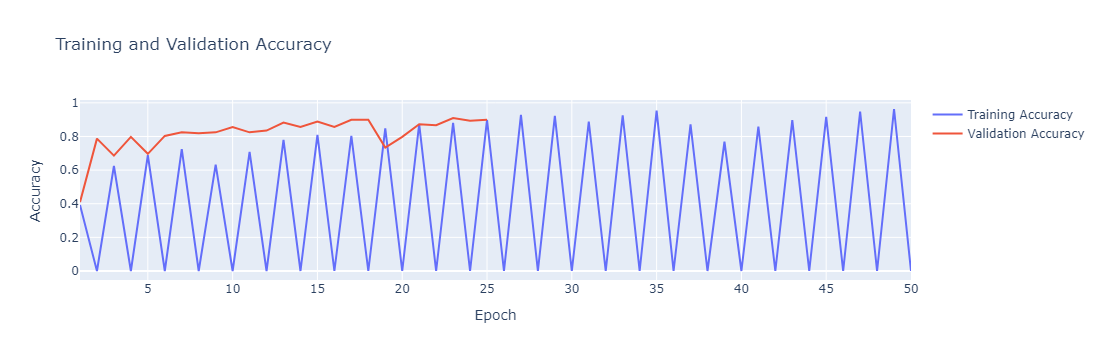

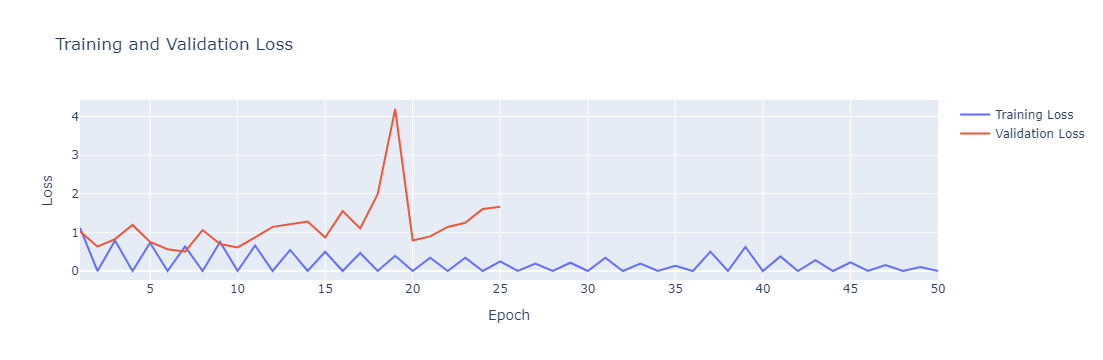

In [51]:
history_plot(epochs, history)

In [52]:
evaluate_model(model_new, test_generator)

C:\Users\Anandan Suresh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



              precision    recall  f1-score   support

           0       0.37      0.35      0.36        63
           1       0.29      0.26      0.27        69
           2       0.30      0.35      0.32        55

    accuracy                           0.32       187
   macro avg       0.32      0.32      0.32       187
weighted avg       0.32      0.32      0.32       187

Test Loss = 0.3441711962223053
Test Accuracy = 0.9304812550544739
Precision = 0.31626957601222305
Recall = 0.3155080213903743
F1 Score = 0.3150684085247032


In [60]:
model_new.save("InceptionResidual_final_v3.h5")
model_new.save("InceptionResidual_final_v3.keras")



In [54]:
model_new.summary()

Model: "inception_residual_network"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 222, 222, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 70, 70, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 70, 70, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_block (InceptionBlock)     │ ?                           │         230,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 21, 21, 128)         │         331,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 21, 21, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block (ResidualBlock)       │ ?                           │         119,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ quad_dense (QuadDense)               │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │          50,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             303 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,352,043 (8.97 MB)

 Trainable params: 783,587 (2.99 MB)

 Non-trainable params: 1,280 (5.00 KB)

 Optimizer params: 1,567,176 (5.98 MB)

In [67]:
from tensorflow.keras.models import load_model

model_path = r"C:\Users\Anandan Suresh\Documents\final year project\InceptionResidual_final_v2.keras" 

model = load_model(model_path, custom_objects={"InceptionResidualNetwork": InceptionResidualNetwork})
model.summary()

Model: "inception_residual_network"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_221 (Conv2D)                  │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_51 (Activation)           │ (None, 222, 222, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_68 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_153              │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_222 (Conv2D)                  │ (None, 70, 70, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_69 (MaxPooling2D)      │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_154              │ (None, 70, 70, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_block_17 (InceptionBlock)  │ ?                           │         230,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_230 (Conv2D)                  │ (None, 21, 21, 128)         │         331,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_71 (MaxPooling2D)      │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_159              │ (None, 21, 21, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_17 (ResidualBlock)    │ ?                           │         119,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_17 (Flatten)                 │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ quad_dense_17 (QuadDense)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,467,650 (5.60 MB)

 Trainable params: 733,184 (2.80 MB)

 Non-trainable params: 1,280 (5.00 KB)

 Optimizer params: 733,186 (2.80 MB)

Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Image: benign 1.jpg
Predicted Class: Malignant, Confidence: 99.94%
------------------------------


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Image: benign 2.jpg
Predicted Class: Malignant, Confidence: 55.46%
------------------------------


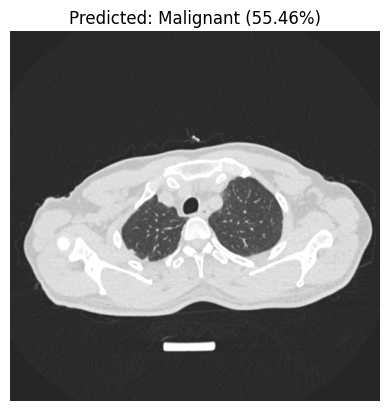

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Image: benign 3.jpg
Predicted Class: Benign, Confidence: 81.48%
------------------------------


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Image: malignant 1.jpg
Predicted Class: Malignant, Confidence: 98.50%
------------------------------


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Image: malignant 2.jpg
Predicted Class: Benign, Confidence: 69.96%
------------------------------


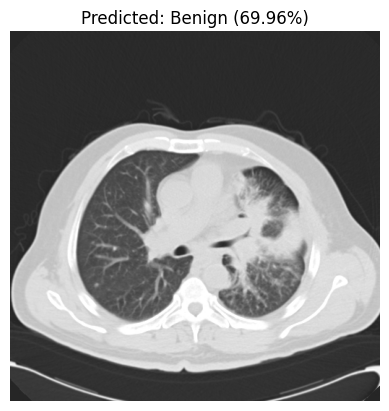

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Image: malignant 3.jpg
Predicted Class: Benign, Confidence: 75.45%
------------------------------


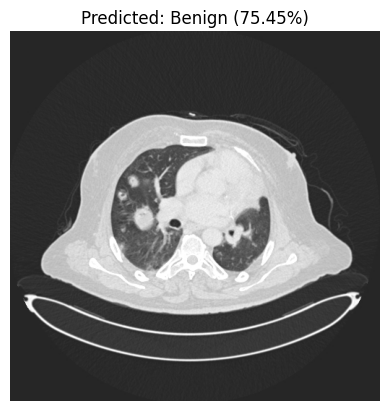

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Image: normal 1.jpg
Predicted Class: Malignant, Confidence: 100.00%
------------------------------


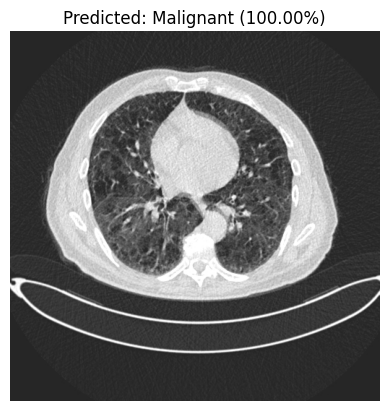

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Image: normal 2.jpg
Predicted Class: Malignant, Confidence: 70.64%
------------------------------


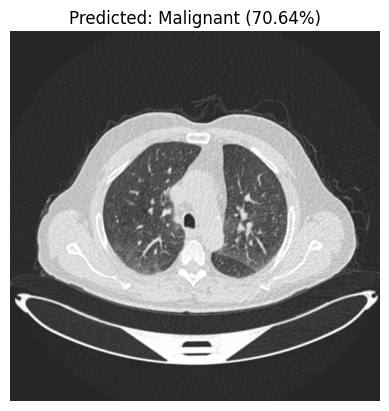

In [65]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt


# Load the trained model
model_path = r"C:\Users\Anandan Suresh\Documents\final year project\InceptionResidual_final_v2.keras" 

model = load_model(model_path, custom_objects={"InceptionResidualNetwork": InceptionResidualNetwork})

# Image preprocessing function
def preprocess_image(image_path, target_size=(224, 224)):  # Replace with your model's input size
    img = load_img(image_path, target_size=target_size)  # Resize the image
    img_array = img_to_array(img)  # Convert to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize the pixel values
    return img_array

# Prediction function
def predict_image(image_path, class_labels):
    # Preprocess the image
    img_array = preprocess_image(image_path)
    
    # Predict using the model
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    confidence = predictions[0][predicted_class] * 100
    
    return class_labels[predicted_class], confidence

# Define class labels
class_labels = ["Benign", "Malignant", "Normal"]  # Update these according to your classes

# Folder containing images to predict
prediction_folder = r"C:\Users\Anandan Suresh\Downloads\test" 
image_files = [os.path.join(prediction_folder, f) for f in os.listdir(prediction_folder) if f.endswith(('.jpg', '.png'))]

# Perform predictions
for image_path in image_files:
    predicted_class, confidence = predict_image(image_path, class_labels)
    print(f"Image: {os.path.basename(image_path)}")
    print(f"Predicted Class: {predicted_class}, Confidence: {confidence:.2f}%")
    print("-" * 30)

    # Optional: Display the image with prediction
    img = load_img(image_path)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()


In [68]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\Anandan Suresh\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Image: Bengin case (35).jpg
Predicted Class: Malignant, Confidence: 100.00%


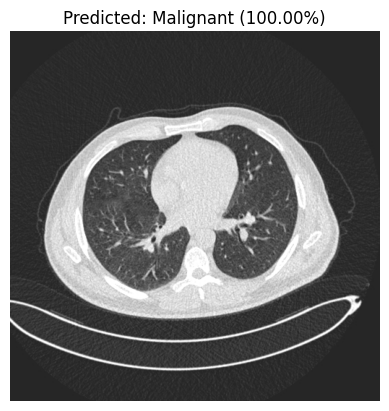

In [48]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Load the trained model
model_path = r"C:\Users\Anandan Suresh\Documents\final year project\InceptionResidual_final_final.keras"

# Ensure `InceptionResidualNetwork` is defined if used as a custom layer
model = load_model(model_path, custom_objects={"InceptionResidualNetwork": InceptionResidualNetwork})

# Image preprocessing function
def preprocess_image(image_path, target_size=(224, 224)):  # Adjust based on model input size
    img = load_img(image_path, target_size=target_size)  # Resize the image
    img_array = img_to_array(img)  # Convert to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize the pixel values
    return img_array

# Prediction function for a **single image**
def predict_single_image(image_path, class_labels):
    img_array = preprocess_image(image_path)
    predictions = model.predict(img_array)
    
    predicted_class = np.argmax(predictions, axis=1)[0]
    confidence = predictions[0][predicted_class] * 100
    
    return class_labels[predicted_class], confidence

# Define class labels
class_labels = ["Benign", "Malignant", "Normal"]  # Update based on your dataset

# Image path (Modify with your image path)
image_path = r"C:\Users\Anandan Suresh\Documents\final year project\lung cancer dataset\Benign cases\Bengin case (35).jpg"  # Update with your test image path

# Perform prediction
predicted_class, confidence = predict_single_image(image_path, class_labels)

# Display results
print(f"Image: {os.path.basename(image_path)}")
print(f"Predicted Class: {predicted_class}, Confidence: {confidence:.2f}%")

# Optional: Display image with prediction
img = load_img(image_path)
plt.imshow(img)
plt.title(f"Predicted: {predicted_class} ({confidence:.2f}%)")
plt.axis('off')
plt.show()


AlexNet

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, Input

In [ ]:
model5 = Sequential([
    Input(shape=(224, 224, 3)), 
    
    Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), padding='valid', activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    BatchNormalization(),
    
    Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    BatchNormalization(),
    
   
    Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
    
    
    Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
    
   
    Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    BatchNormalization(),
    
    
    Flatten(),
    
    
    Dense(4096, activation='relu'),
    Dropout(0.5),
    
    
    Dense(4096, activation='relu'),
    Dropout(0.5),
    
    
    Dense(3, activation='softmax')
])


model5.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  
    metrics=['accuracy']
)

In [ ]:
epochs=50
history = model5.fit(train_generator,
                   steps_per_epoch = len(train_generator),
                   batch_size = 32,
                   validation_data = val_generator,
                   validation_steps = len(val_generator),
                   class_weight = train_class_weights,
                   # callbacks=[
                   #             EarlyStopping(monitor = "val_loss",patience = 5,restore_best_weights = True), 
                   #             ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, mode='min') 
                   #            ],
                   epochs = epochs)

In [ ]:
evaluate_model(model5, test_generator)

In [ ]:
models = [model1, model2, model3,model4,model_new,model5]
loss = []
accuracy = []
name_models = ["CNN (Custom)", "InceptionV3", "VGG16","InceptionResidual","InceptionResidual(Weights)","AlexNet"]
for index,model in enumerate(models):
    
    results = model.evaluate(test_generator, verbose = 0)
    print(f"{name_models[index]}:\nLoss={results[0]} \nAccuracy={results[1]}\n")
    loss.append(results[0])
    accuracy.append(results[1])

In [ ]:
import plotly.express as px


In [ ]:
name_models = ["CNN (Custom)", "InceptionV3", "VGG16","InceptionResidual","InceptionResidual(Weights)","AlexNet"]
df_loss_acc = pd.DataFrame(data = {"Name_Models" : name_models,
                                  "Loss" : loss,
                                  "Accuracy" : accuracy})

fig = px.bar(data_frame = df_loss_acc, x = "Name_Models", y = ["Accuracy", "Loss"],
            barmode = "group",
            text_auto = ".3f")
fig.show()

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
import streamlit as st
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from PIL import Image
from tensorflow.keras.utils import get_custom_objects
from Inception import InceptionResidualNetwork

model_path = r"C:\Users\Anandan Suresh\Documents\final year project\InceptionResidual_final_final.keras" 


model = load_model(model_path, custom_objects={"InceptionResidualNetwork": InceptionResidualNetwork})


# Define class labels
class_labels = ["Benign", "Malignant", "Normal"] 

def preprocess_image(image, target_size=(224, 224)):
    image = image.resize(target_size)
    img_array = img_to_array(image)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

def predict_classification(image):
    img_array = preprocess_image(image)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    confidence = predictions[0][predicted_class] * 100
    return class_labels[predicted_class], confidence

# Streamlit UI
st.title("Bone Tumor Classification")
uploaded_file = st.file_uploader("Upload an X-ray/CT Image", type=["jpg", "png", "jpeg"])

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption="Uploaded Image", use_column_width=True)
    
    if st.button("Classify Tumor"):
        predicted_class, confidence = predict_classification(image)
        st.write(f"**Prediction:** {predicted_class} ({confidence:.2f}%)")
